In [1]:
import numpy as np
from implementations import *
from logistic_regression import *
from helpers import *
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore")

### Load Data

In [18]:
y, x, id = load_csv_data("data/train.csv")
print(x.shape, y.shape)

(250000, 30) (250000,)


### Data Exploration

In [4]:
np.unique(y, return_counts=True)
# Here can observe unbalance.

(array([-1.,  1.]), array([164333,  85667], dtype=int64))

In [5]:
np.count_nonzero(x == -999, axis = 0) # finding the the columns which have undefined values

array([ 38114,      0,      0,      0, 177457, 177457, 177457,      0,
            0,      0,      0,      0, 177457,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,  99913,
        99913,  99913, 177457, 177457, 177457,      0], dtype=int64)

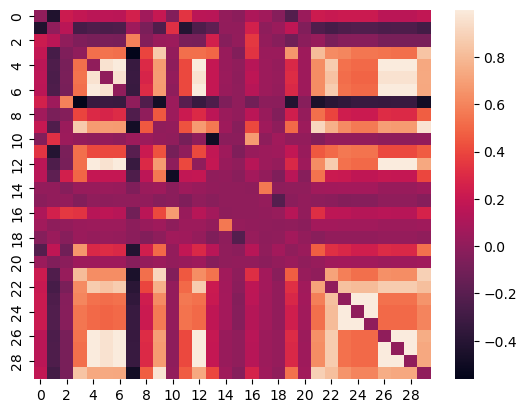

In [19]:
# Plotting correlation matrix:
# Some features have a high correlation especially those with a huge amount of missing values.

def correlation(x):
    corr = np.zeros((x.shape[1], x.shape[1]))
    for i in range(x.shape[1]):
        for j in range(x.shape[1]):
            if i!=j:
                corr[i][j] = np.corrcoef(x = x[:1000, i], y= x[:1000, j])[0, 1]
    return corr 

sns.heatmap(correlation(x));

@Alya 

linear dependance of low correlation values

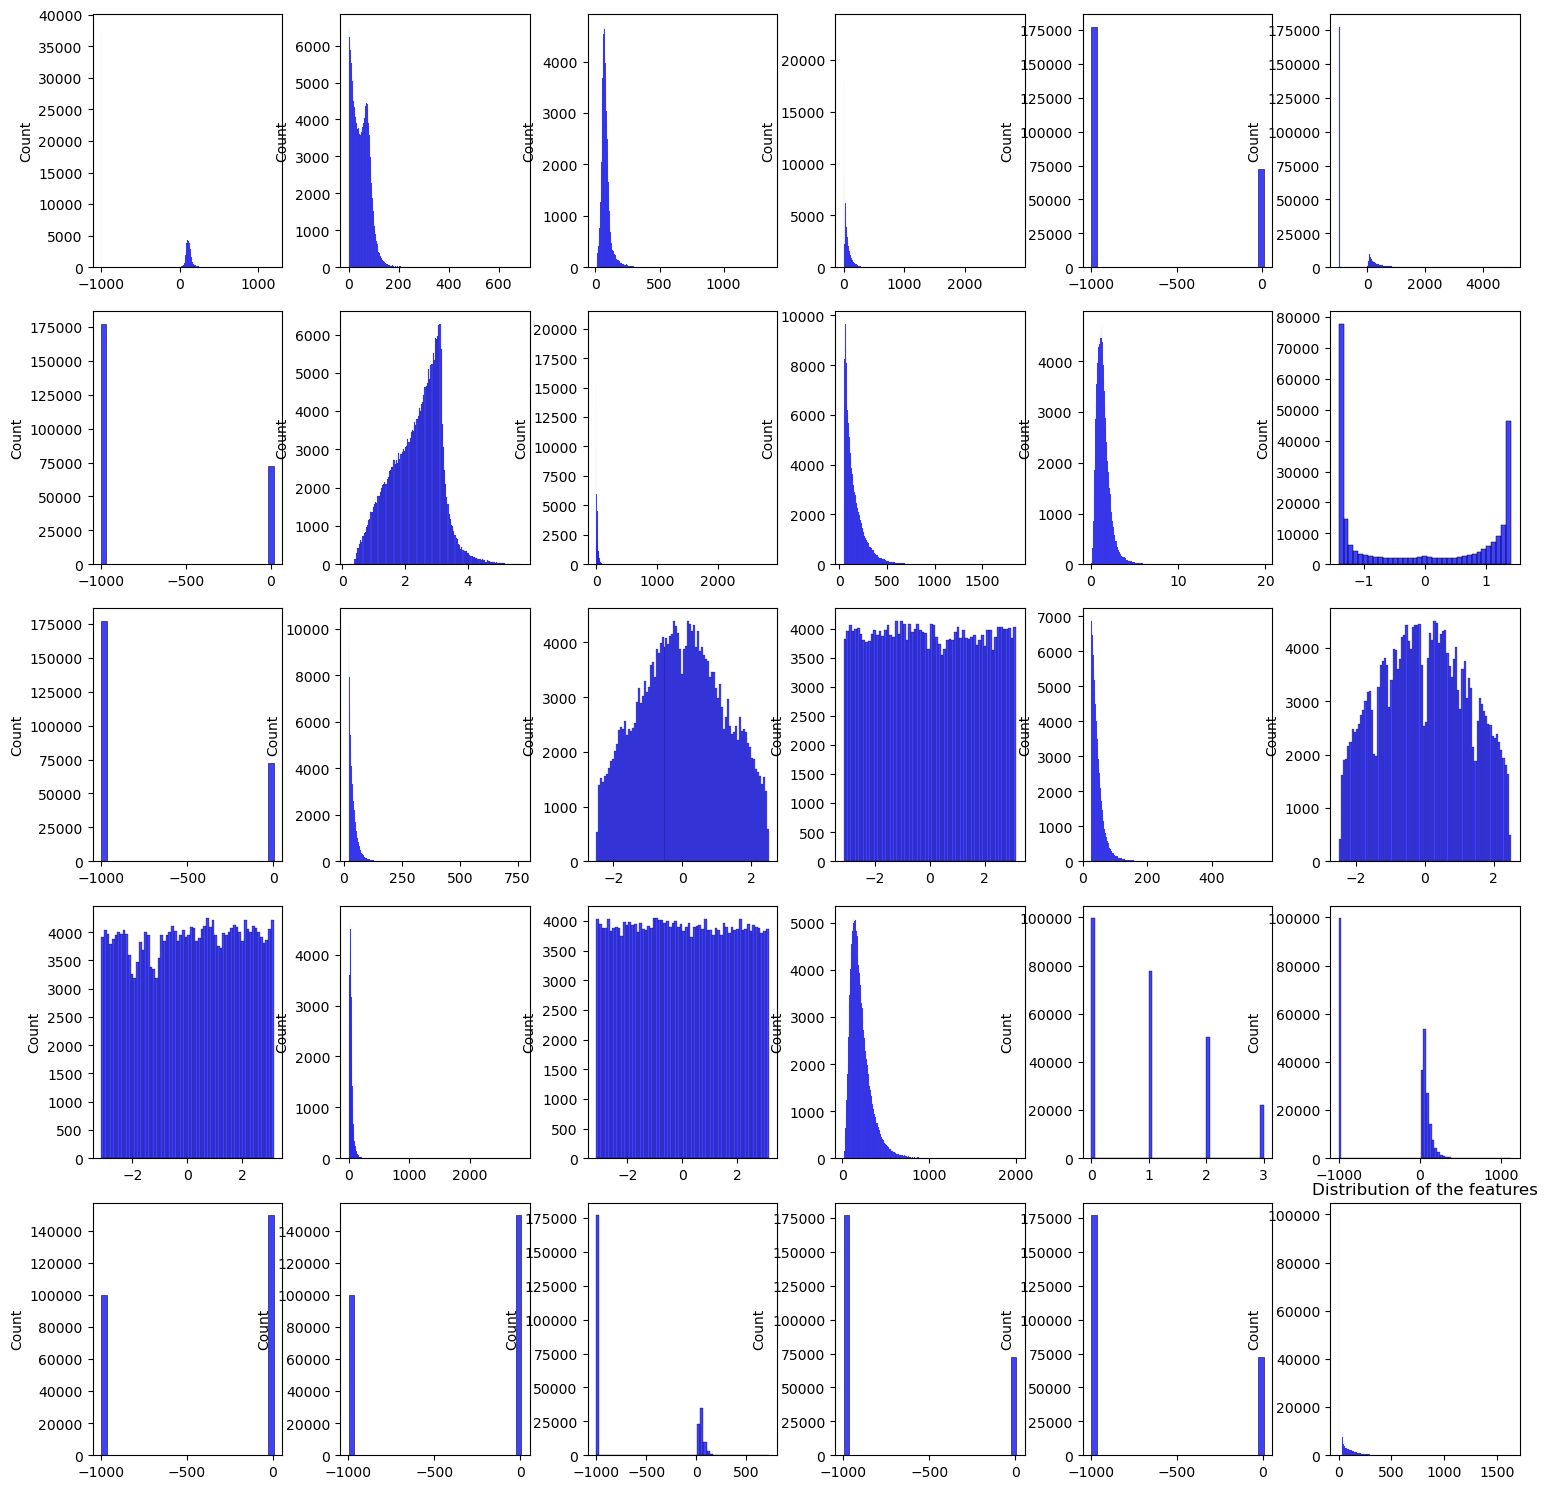

In [5]:
f, axes = plt.subplots(5, 6, figsize=(15, 15))
f.tight_layout()
for i, ax in zip(x.T, axes.flatten()):
    scores = i 
    sns.histplot(scores, ax=ax, color='b')
    
plt.title("Distribution of the features")
plt.show();

We should use Log Transform to convert a skewed distributions to a less-skewed distributions.

### Data Processing

In [6]:
# First of all, the number of missing values of some columns is equal, so we can simply create 
# new features with 0 or 1 whether there is -999, that will correspond to these columns.
# And will see if we include it later or not.

features_with_missing = np.count_nonzero(x == -999, axis = 0)
duplicates = np.unique(features_with_missing)
col1 = []
cols_1 = []
for i in range(len(duplicates)):
    col1.append(len(np.argwhere(features_with_missing == np.amax(features_with_missing)).flatten().tolist()))
    cols_1.append([1 if t==-999 else 0 for t in x[:, i]])
    features_with_missing = np.delete(features_with_missing, col1, axis=0)


In [20]:
# Imputer to replace missing values with the median of certain column

def imputer(data):
    data[data == -999] = np.nan
    col_mean = np.nanmedian(data, axis=0)
    inds = np.where(np.isnan(data))
    data[inds] = np.take(col_mean, inds[1])
    return data
    
# X = imputer(x)
# x.shape

In [8]:
# One-hot encoding

col = []
for i in np.unique(X[:, -8]):
    col.append([1 if t==i else 0 for t in X[:, -8]])
X = np.delete(X, 22, axis = 1)

In [9]:
# Log transformation

# positive_cols = [0,1,2,3,4,5,7,8,9,10,12,13,16,19,21,23,26] # np.log(1 / (1 + X[:, positive_cols]))
x_log_transform = np.sign(X)*np.log(np.abs(X)+1) 
X = np.hstack([X, x_log_transform])
X.shape

(250000, 58)

In [9]:
# to_drop = np.where(correlation(X)>=0.9)
# X = np.delete(X, np.unique(to_drop), axis = 1)

In [21]:
def build_poly(poly, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree.
    """
    for i in range(poly.shape[1]):
        for j in range(2, degree + 1):
            poly = np.concatenate((poly, np.array(poly[:, i]**j).reshape(poly.shape[0], 1)), axis=1)
    return poly

# X = build_poly(X, 2)

In [11]:
# standardization and concatenation of other columns

X = standardize(X)[0]
X = np.concatenate((X, np.ones((len(X), 1))), axis=1)
for i in range(len(col1)):
    X = np.concatenate((X, np.array(cols_1[i]).reshape(len(cols_1[i]), 1)), axis=1)
X = np.concatenate((X, np.array(col).reshape(len(col[-1]), 4)), axis = 1)


In [22]:
def replace(data, value, new_value):
    data[data == value] = new_value
    return data

# y = replace(y, -1, 0)

In [25]:
x_train, x_test, y_train, y_test = split_data(X, y, 0.80)

# Balancing the data 

# w_class0 = np.where(y_train == -1)[0]
# w_class1 = np.where(y_train == 1)[0]
# w_class0_downsampled = np.random.choice(w_class0, size=int(w_class0.shape[0]*0.75), replace=True)
# y_train = np.hstack((y_train[w_class1], y_train[w_class0_downsampled]))
# x_train = np.vstack((x_train[w_class1], x_train[w_class0_downsampled]))

In [51]:
np.unique(y_train, return_counts=True)

(array([0., 1.]), array([131563,  68437], dtype=int64))

In [26]:
model_lg = Logistic_Regression(0.6)
model_lg.train(x_train, y_train)
print(model_lg.train_accuracy)
model_lg.test(x_test, y_test)
print(model_lg.test_accuracy)

d:\VSC_projects\ML_Higgs\logistic_regression.py:25: RuntimeWarning: divide by zero encountered in log
  return np.sum(-(1 / y.shape[0]) * (y.T.dot(np.log(self.sigmoid(tx.dot(w))))+ (1 - y).T.dot(np.log(1 - self.sigmoid(tx.dot(w))))))


0.815385
0.8132


In [25]:
def one_hot_missing(x):
    features_with_missing = np.count_nonzero(x == -999, axis = 0)
    duplicates = np.unique(features_with_missing)
    col1 = []
    cols_1 = []
    for i in range(len(duplicates)):
        col1.append(len(np.argwhere(features_with_missing == np.amax(features_with_missing)).flatten().tolist()))
        cols_1.append([1 if t==-999 else 0 for t in x[:, i]])
        features_with_missing = np.delete(features_with_missing, col1, axis=0)
        
    return col1, cols_1


def preprocess(x, y, degree):
    # 1
    col_missing, representation = one_hot_missing(x)
    # 2 
    x = imputer(x)
    col = []
    for i in np.unique(x[:, -8]):
        col.append([1 if t==i else 0 for t in x[:, -8]])
    x = np.delete(x, 22, axis = 1)
    # 3
    x_log_transform = np.sign(x)*np.log(np.abs(x)+1) 
    x = np.hstack([x, x_log_transform])
    # 4
    x = build_poly(x, 2)
    # 5
    x = standardize(x)[0]
    # 6
    x = np.concatenate((x, np.ones((len(x), 1))), axis=1)
    for i in range(len(col_missing)):
        x = np.concatenate((x, np.array(representation[i]).reshape(len(representation[i]), 1)), axis=1)
    x = np.concatenate((x, np.array(col).reshape(len(col[-1]), 4)), axis = 1)
    # 7
    y = replace(y, -1, 0)
    return x, y

In [26]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold.
    """
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval] for k in range(k_fold)]
    return np.array(k_indices)


def run_model(k_indices, k, gamma, g):
    ind = np.concatenate((k_indices[:k], k_indices[k+1:])).flatten()
    x_test = x[k_indices[k]]
    x_train = x[ind]
    y_test = y[k_indices[k]]
    y_train = y[ind]
    x_train, y_train = preprocess(x_train, y_train, g)
    x_test, y_test = preprocess(x_test,y_test, g)
                
    model = Logistic_Regression(gamma)
    model.train(x_train, y_train)
    model.test(x_test, y_test)
    return model.train_accuracy, model.test_accuracy


def cross_validation(degrees, k_fold, gammas):
    """cross validation over regularisation parameter lambda.
    """
    seed = 12
    degrees = degrees
    k_fold = k_fold
    gammas = gammas
    k_indices = build_k_indices(y, k_fold, seed)
    acc_tr, acc_te = [], []
    gammas_array = []
    degrees_array = []
    
    for gamma_ in gammas:
        for g in degrees:
            trl, tel = [], []
            for i in range(k_fold):
                train_accuracy, test_accuracy = run_model(k_indices, i, gamma_, g)
                trl.append(train_accuracy)
                tel.append(test_accuracy)
                
            acc_tr.append(np.mean(trl))
            acc_te.append(np.mean(tel))
            degrees_array.append(g)
            gammas_array.append(gamma_)
            
    best_acc = np.max(acc_te)
    best_gamma = gammas_array[np.argmax(acc_te)]
    best_degree = degrees_array[np.argmax(acc_te)]
    cross_validation_visualization(gammas_array, acc_tr, acc_te)
    cross_validation_visualization(degrees_array, acc_tr, acc_te)
    print("For polynomial expansion up to degree %.f, the choice of lambda which leads to the best test rmse is %.5f with a test rmse of %.3f" % (best_degree, best_gamma, best_acc))
    return best_gamma, best_acc, best_degree

best_gamma, best_acc, best_degree = cross_validation(np.arange(2, 4), 4, np.logspace(-4, 0, 20))

KeyboardInterrupt: 

In [ ]:
model_lg = Logistic_Regression(best_gamma)
model_lg.train(x_train, y_train)
print(model_lg.train_accuracy)
model_lg.test(x_test, y_test)
print(model_lg.test_accuracy)